In [ ]:
## 0. load packages
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from datetime import datetime
from matplotlib.lines import Line2D

os.chdir('/h/u145/liuxinrui/CROP/')
sys.path.insert(0, '/h/u145/liuxinrui/CROP/')

spcs = ['mai', 'ri1', 'ri2', 'soy', 'wwh', 'swh']
spcs4 = ['mai', 'ric', 'soy', 'whe']
crop_mapping = {'mai': 'maize', 'ric': 'rice', 'soy': 'soybean', 'whe':'wheat'}
impact_models =  ['CYGMA1p74', 'EPIC-IIASA', 'ISAM', 'LDNDC', 'LPJmL', 'PEPIC', 'PROMET', 'SIMPLACE-LINTUL5']
colors = ['tab:green', 'tab:blue', 'tab:orange']

run_yr = (1960, 2020)
nMC = 1000

In [14]:
## 1. load parameters

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_loadP_CROP import load_ISIMIP3b_param
Par = load_ISIMIP3b_param()
Par['N_bnf'] = Par['N_bnf'].sel(mod_bnf_soy='Ma_2022').squeeze()
Par = Par.drop_dims(['mod_bnf_soy'])
print(Par)

## generate MC parameters
from core_fct.fct_genMC import extrat_crop_par, restore_crop_par, generate_config
print(Par['YD_0'].sel(spc_crop='ri1', reg_land=287, irr='noirr').values)
Par1 = extrat_crop_par(Par)
Par0 = restore_crop_par(Par1)
print(Par0['YD_0'].sel(spc_crop='ri1', reg_land=287, irr='noirr').values)
Par2 = generate_config(Par1, nMC=nMC, kde_to_mod=False, mod_to_unc=False, mod_noise=0.1, seed=1997)
Par = restore_crop_par(Par2)
print(Par['YD_0'].sel(spc_crop='ri1', reg_land=287, irr='noirr').values)


++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-20 13:12:41.741732
++++++++++++++++++++++++++++++++++++++++++++++++++ 

loading primary parameters
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
<xarray.Dataset>
Dimensions:        (reg_land: 292, mod_clim_gcm: 5, spc_crop: 6, irr: 2,
                    mod_YD_crop: 8)
Coordinates:
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
    reg_land_code  (reg_land) object 'AFG' 'ALA' 'ALB' ... 'YEM' 'ZMB' 'ZWE'
    reg_land_name  (reg_land) object 'Afghanistan' 'Aland' ..

In [ ]:
## 2. prepare drivers

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

For_co2 = xr.load_dataset('input_data/observations/crop/concentrations_ClimateIndicator.nc')['CO2'].sel(year=slice(*run_yr))
For_co2 = For_co2 - Par['CO2_0']
For_co2.name = 'D_CO2'

For_3a = xr.load_dataset('input_data/observations/crop/land-climate_ISIMIP3a.nc').sel(data='20CRv3-ERA5', drop=False).expand_dims('data', -1).assign_coords(data=['20CRv3-ERA5'])
For_cru = xr.load_dataset('input_data/observations/crop/land-climate_CRU-TS4.09.nc').expand_dims('data', -1).assign_coords(data=['CRU-TS4.09'])
For_clim = xr.concat([For_3a, For_cru], dim='data')
For_clim = For_clim - For_clim.sel(year=slice(1901, 1930)).mean('year')
For_clim = For_clim.rename({'Tl': 'D_Tl', 'Pl': 'D_Pl', 'data':'data_clim'}).sel(year=slice(*run_yr)).squeeze()
print(For_clim)

from core_fct.fct_loadD_CROP import load_Nfertl_hist, load_Ndep_hist
soc = 'histsoc'
For_Nfertl = load_Nfertl_hist(datasets=['Adalibieke_2023']).sel(year=slice(*run_yr)).squeeze()
print(For_Nfertl)

Par['N_fertl_0'] = For_Nfertl['N_fertl'].sel(year=2015, drop=True)
print(Par['N_fertl_0'])

For_Ndep = load_Ndep_hist(datasets=['ISIMIP3b']).sel(year=slice(*run_yr)).squeeze()
print(For_Ndep)

For = xr.merge([For_co2, For_clim, For_Nfertl, For_Ndep])
print(For)

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-20 13:12:49.951727
++++++++++++++++++++++++++++++++++++++++++++++++++ 

<xarray.Dataset>
Dimensions:        (year: 61, reg_land: 292, data_clim: 2)
Coordinates:
  * year           (year) int64 1960 1961 1962 1963 1964 ... 2017 2018 2019 2020
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
  * data_clim      (data_clim) <U11 '20CRv3-ERA5' 'CRU-TS4.09'
    reg_land_name  (reg_land) object 'Afghanistan' 'Aland' ... 'Zimbabwe'
    reg_land_code  (reg_land) object 'AFG' 'ALA' 'ALB' ... 'YEM' 'ZMB' 'ZWE'
Data variables:
    D_Tl           (year, reg_land, data_clim) float64 nan nan nan ... nan nan
    D_Pl           (year, reg_land, data_clim) float64 nan nan nan ... nan nan
Loading 1 datasets for sub-national region
Loading nitrogen_fertl__Adalibieke_2023_sub-national ...
<xarray.Dataset>
Dimensions:        (year: 60, spc_crop: 6, reg_land: 292)
Coordinates:
  * year           (ye

In [16]:
## 3. Output parameters and drivers

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

Par.to_netcdf('results/historical/Par.nc')
For.to_netcdf('results/historical/For.nc')

print('Parameters and drivers saved to results/Par.nc and results/For.nc')

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-20 13:12:50.828132
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Parameters and drivers saved to results/Par.nc and results/For.nc


In [ ]:
## 4. run CROP emulator

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.mod_process_CROP import CROP
CROP = CROP()
print(CROP.var_in)

Out = CROP(None, Par, For, var_keep=['D_Tgs', 'D_Pgs', 'NI', 'RC', 'RT', 'RP', 'RN', 'YD'])
Out.to_netcdf('results/historical/results_historical.nc')

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-12 13:41:19.439734
++++++++++++++++++++++++++++++++++++++++++++++++++ 

{'N_fertl', 'D_Pl', 'D_Tl', 'D_CO2', 'N_dep'}


In [ ]:
## 5. prepare 4 crop yields

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

USE_IRR = 'all'
YD = xr.load_dataset('results/historical/results_historical.nc')['YD']

# load irrgation cropland area
from core_fct.fct_loadD_CROP import load_cropland_hist
if USE_IRR == 'all': 
    Ac = load_cropland_hist(irr_flag=True).squeeze()['Ac']
    ## extend to the lat year of simulation
    from scipy.stats import theilslopes
    Ac_trends = np.nan * Ac.sum('year')
    for reg in Ac_trends.reg_land:
        for spc in Ac_trends.spc_crop:
            for irr in Ac_trends.irr:
                Ac_trends.loc[{'reg_land': reg, 'spc_crop': spc, 'irr': irr}] = theilslopes(Ac.isel(year=slice(-10, None)).sel(spc_crop=spc, reg_land=reg, irr=irr).values)[0]
    Ac = xr.concat([Ac] + [Ac.isel(year=-1).assign_coords(year=int(Ac.year[-1]) + n) + n * Ac_trends for n in range(1, 1 + int(run_yr[-1]) - int(Ac.year[-1]))], dim='year')
    YD = YD.weighted(Ac).mean('irr').rename('YD')
if USE_IRR == 'firr': YD = YD.sel(irr='firr', drop=True).rename('YD')
if USE_IRR == 'noirr': YD = YD.sel(irr='noirr', drop=True).rename('YD')

# transform sub-regions into national regions
from core_fct.fct_pre_CROP import aggreg_subreg
Ac = load_cropland_hist(irr_flag=False).squeeze()['Ac']
## extend to the lat year of simulation
Ac_trends = np.nan * Ac.sum('year')
for reg in Ac_trends.reg_land:
    for spc in Ac_trends.spc_crop:
            Ac_trends.loc[{'reg_land': reg, 'spc_crop': spc}] = theilslopes(Ac.isel(year=slice(-10, None)).sel(spc_crop=spc, reg_land=reg).values)[0]
Ac = xr.concat([Ac] + [Ac.isel(year=-1).assign_coords(year=int(Ac.year[-1]) + n) + n * Ac_trends for n in range(1, 1 + int(run_yr[-1]) - int(Ac.year[-1]))], dim='year')
ds_YD = xr.merge([YD, Ac])
(ds_YD, ) = xr.broadcast(ds_YD)
ds_YD = aggreg_subreg(ds_YD, weight_var='Ac', weight_calc='mean', keep_sub=False)
yd_6 = ds_YD['YD']

#load harvested area
from core_fct.fct_loadD_CROP import load_harvested_hist
area_harv = load_harvested_hist(mod_region='national')

## combine ri1 and ri2
area_ric_harv = area_harv['Ah'].sel(spc_crop=['ri1', 'ri2'])
area_ric_harv = area_ric_harv.where(area_ric_harv > 0).dropna('data_Ah', how='all').squeeze().fillna(0)
yd_ric = yd_6.sel(spc_crop=['ri1', 'ri2']).weighted(area_ric_harv).mean('spc_crop').assign_coords(spc_crop='ric').expand_dims('spc_crop').rename('YD')

## combine swh and wwh
area_whe_harv = area_harv['Ah'].sel(spc_crop=['swh', 'wwh'])
area_whe_harv = area_whe_harv.where(area_whe_harv > 0).dropna('data_Ah', how='all').squeeze().fillna(0)
yd_whe = yd_6.sel(spc_crop=['swh', 'wwh']).weighted(area_whe_harv).mean('spc_crop').assign_coords(spc_crop='whe').expand_dims('spc_crop').rename('YD')

yd_4 = xr.merge([yd_6.sel(spc_crop=['mai', 'soy']), yd_ric, yd_whe])
yd_4.to_netcdf(f'results/historical/YD4_{USE_IRR}.nc')


++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-16 16:16:49.956608
++++++++++++++++++++++++++++++++++++++++++++++++++ 

Loading 9 datasets for national region
Loading harvested-area__Adalibieke_2023_sub-national ...
>>> Running aggreg_subreg <<<
Loading harvested-area__Waha_2020_sub-national ...
>>> Running aggreg_subreg <<<
Loading harvested-area__Becker-Reshef_2023_sub-national ...
>>> Running aggreg_subreg <<<
Loading harvested-area__CROPGRIDSv1.07_national ...
Loading harvested-area__RiceAtlas_national ...
Loading harvested-area__MIRCA2000_sub-national ...
>>> Running aggreg_subreg <<<
Loading harvested-area__Monfreda_2008_sub-national ...
>>> Running aggreg_subreg <<<
Loading harvested-area__ric-ISIMIP3b_sub-national ...
>>> Running aggreg_subreg <<<
Loading harvested-area__FAO_national ...
>>> Running aggreg_region <<<
>>> Running aggreg_region <<<
>>> Running aggreg_region <<<
>>> Running aggreg_region <<<


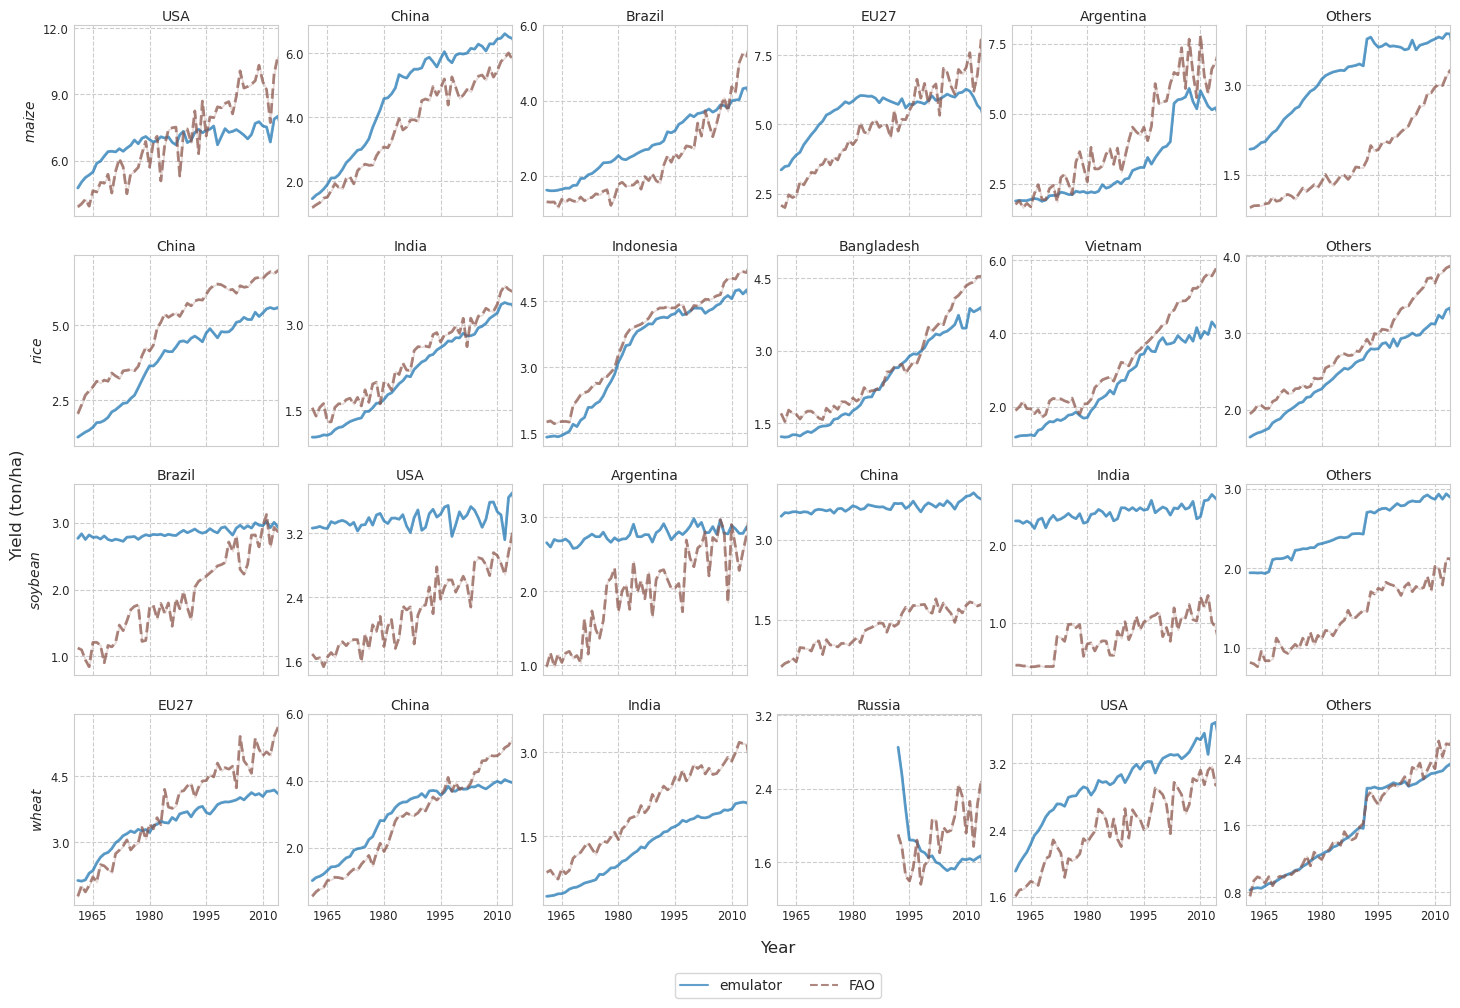

In [ ]:
## 6. top five producers

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_pre_CROP import aggreg_region
reg_p = {'mai': 'Maize', 'ric': 'Rice', 'soy': 'Soybean', 'whe': 'Wheat'}

source = 'FAO'
## show the uncertainty from fertilizer
USE_NI = True
dim_avg = ['config', 'data_clim', 'data_Ac', 'data_Ah']
fn = f'results/historical/YD4_all.nc'
yd = xr.load_dataarray(fn).mean(dim_avg).squeeze()
yd_obs = xr.load_dataarray(f'input_data/observations/crop/yield__{source}_national.nc').sel(year=slice(1960, run_yr[-1])).rename('YD_in')

from core_fct.fct_loadD_CROP import load_harvested_hist
Ah = load_harvested_hist(crop_species=['mai', 'ric', 'soy', 'whe'], mod_region='national').squeeze()['Ah'].sel(year=slice(1960, run_yr[-1])).rename({'data_Ah': 'weight_Ah'})

## only use data available in both datasets
cond = (yd.notnull() & yd_obs.notnull())
yd = yd.where(cond).rename('YD')
yd_obs = yd_obs.where(cond).rename('YD_in')

ds_obs = xr.merge([yd, yd_obs, Ah]).dropna(dim='year', how='all')

AGG = True
if AGG:
    Var0 = []
    Var_mod = ds_obs.rename({'reg_land': 'reg_land_new'})
    for spc in Var_mod.spc_crop.values:
        Var_spc = Var_mod.sel(spc_crop=spc)
        Var_spc = aggreg_region(Var_spc, reg_p[spc], 
                    weight_var={'YD': 'Ah', 'YD_in': 'Ah'}, 
                    old_axis='reg_land_new', new_axis='reg_land', time_axis='year', dataset=None
                )
        Var0.append(Var_spc)
    Var_mod = xr.concat(Var0, dim='spc_crop').mean('weight_Ah')

sns.set_style('whitegrid')
legend_handles = []
label_handles = []
fig, axs = plt.subplots(len(spcs4), len(Var_mod.reg_land), figsize=(16, 10), sharex=True)
for s, spc in enumerate(spcs4):
    for r, reg in enumerate(Var_mod.reg_land.values):
        ax = axs[s, r]
        ax.set_xlim(1960, 2014)
        ax.tick_params(axis='both', direction='in')
        ax.xaxis.set_tick_params(labelsize='small')
        ax.yaxis.set_tick_params(labelsize='small')
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

        df_reg = Var_mod.sel(spc_crop=spc, reg_land=reg).to_dataframe()
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD',
                    c='tab:blue',
                    alpha=0.7,
                    lw=2,
                    ax=ax,
                    errorbar=('pi', 100)
        )
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD_in',
                    c='tab:brown',
                    ls='--',
                    alpha=0.7,
                    lw=2,
                    ax=ax
        )
        ax.set_title(f'{Var_mod['reg_land_name_'+reg_p[spc]].sel(reg_land=reg).values}', y=0.98, fontsize='medium')
        ax.grid(True, linestyle='--')
        if r == 0: 
            ax.set(xlabel='', ylabel=rf'$\it{{{crop_mapping[spc]}}}$')
        else:
            ax.set(xlabel='', ylabel='')

fig.supxlabel(r'Year', y=0.05)
fig.supylabel(r'Yield (ton/ha)', x=0.02)

legend = [ Line2D([0, 1], [0, 1], alpha=0.7, c='tab:blue', ls='-', label=rf'emulator'), 
          Line2D([0, 1], [0, 1], alpha=0.7, c='tab:brown', ls='--', label=f'{source}')]
fig.legend(handles=legend, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.0))
plt.subplots_adjust(left=0.06, bottom=0.1, right=0.92, top=0.98, wspace=0.15, hspace=0.2)
plt.show()
plt.savefig('results/historical/fao.png')

In [ ]:
## 7. overall alignment

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_pre_CROP import stack_dims
from sklearn.metrics import mean_squared_error

reg_p = {'mai': 'Maize', 'ric': 'Rice', 'soy': 'Soybean', 'whe': 'Wheat'}

source = 'FAO'
USE_IRR = 'all'
fn = f'results/historical/YD4_{USE_IRR}.nc'
yd = xr.load_dataarray(fn).sel(year=slice(1960, run_yr[-1])).rename('YD')
yd_obs = xr.load_dataarray(f'input_data/observations/crop/yield__{source}_national.nc').sel(year=slice(1960, run_yr[-1])).rename('YD_in')
## the order of stacked dimensions should be the same
yd = stack_dims(yd, ['config', 'data_clim', 'data_N_fertl', 'data_Ac', 'data_Ah'], 'new_dims')

fn_dist = f'results/historical/dist_{source}_{USE_IRR}.nc'
if os.path.exists(fn_dist):
    print(f'loading {fn_dist}')
    dist = xr.load_dataarray(fn_dist)
else:
    dist = xr.DataArray(
        np.nan * np.zeros((len(yd.reg_land), len(yd.spc_crop), len(yd.new_dims))),
        dims=[ 'reg_land', 'spc_crop', 'new_dims'],
        coords={'reg_land': yd.reg_land.values, 'spc_crop': yd.spc_crop.values, 'new_dims': yd.new_dims.values},
        name='RRMSE'
    )
    for data in yd.new_dims.values:
        for reg in yd.reg_land.values:
            for spc in yd.spc_crop.values:
                yd_config = yd.sel(spc_crop=spc, reg_land=reg, new_dims=data, drop=True)
                if yd_config.notnull().sum() == 0: continue
                yd_obs_reg = yd_obs.sel(spc_crop=spc, reg_land=reg, drop=True)
                if yd_obs_reg.notnull().sum() == 0: continue
                cond = (yd_config.notnull() & yd_obs_reg.notnull())
                yd_config = yd_config.where(cond).dropna(dim='year')
                yd_obs_reg = yd_obs_reg.where(cond).dropna(dim='year')
                if len(yd_obs_reg) == 0: continue
                dist.loc[{'spc_crop':spc, 'reg_land': reg, 'new_dims': data}] = mean_squared_error(yd_config, yd_obs_reg) / yd_obs_reg.mean().values
    dist.to_netcdf(fn_dist)

for reg in yd.reg_land.values:
    fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True)
    for spc in yd.spc_crop.values:
        ax = axs.flat[spcs4.index(spc)]
        ax.set_xlim(1960, run_yr[-1])
        ax.tick_params(axis='both', direction='in')
        ax.xaxis.set_tick_params(labelsize='small')
        ax.yaxis.set_tick_params(labelsize='small')
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
        ax.set_title(f'{crop_mapping[spc]}')
        
        dist_reg = dist.sel(spc_crop=spc, reg_land=reg, drop=True)
        for ind, qt_val in enumerate([0.3, 0.5, 1.0]):
            qt = dist_reg.quantile(qt_val, dim='new_dims')
            cond = ((dist_reg >= 0) & (dist_reg <= qt))
            yd_reg = yd.sel(spc_crop=spc, reg_land=reg, drop=True)
            yd_reg = yd_reg.where(cond).dropna('new_dims', how='all')
            sns.lineplot(data=yd_reg.to_dataframe(), x='year', y='YD', ax=ax, color=colors[ind], lw=1, alpha=0.7, errorbar=('pi', 100))
            ax.text(0.5, 0.95-ind*0.1, f'{qt_val} RRMSE quantile: {qt*100:.1f}%', color=colors[ind], ha='center', va='top', transform=ax.transAxes, fontsize=8)
            
        yd_obs_reg = yd_obs.sel(spc_crop=spc, reg_land=reg, drop=True)
        sns.lineplot(data=yd_obs_reg.to_dataframe(), x='year', y='YD_in', ax=ax, color='tab:brown', lw=2, ls='--', alpha=0.7)
        ax.set(xlabel='', ylabel='')
        ax.grid(True, linestyle='--', alpha=0.5)
    fig.supxlabel(r'Year', x=0.5, y=0.01)
    fig.supylabel(r'Yield (ton/ha)', x=0)
    fig.suptitle(f'{yd.reg_land_name.sel(reg_land=reg, drop=True).values}')
    pic = f'results/historical/fig/YD_{source}_{USE_IRR}_{reg}.png'
    plt.savefig(pic, dpi=300, bbox_inches='tight')
    plt.close()

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-16 13:55:19.609904
++++++++++++++++++++++++++++++++++++++++++++++++++ 

>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...


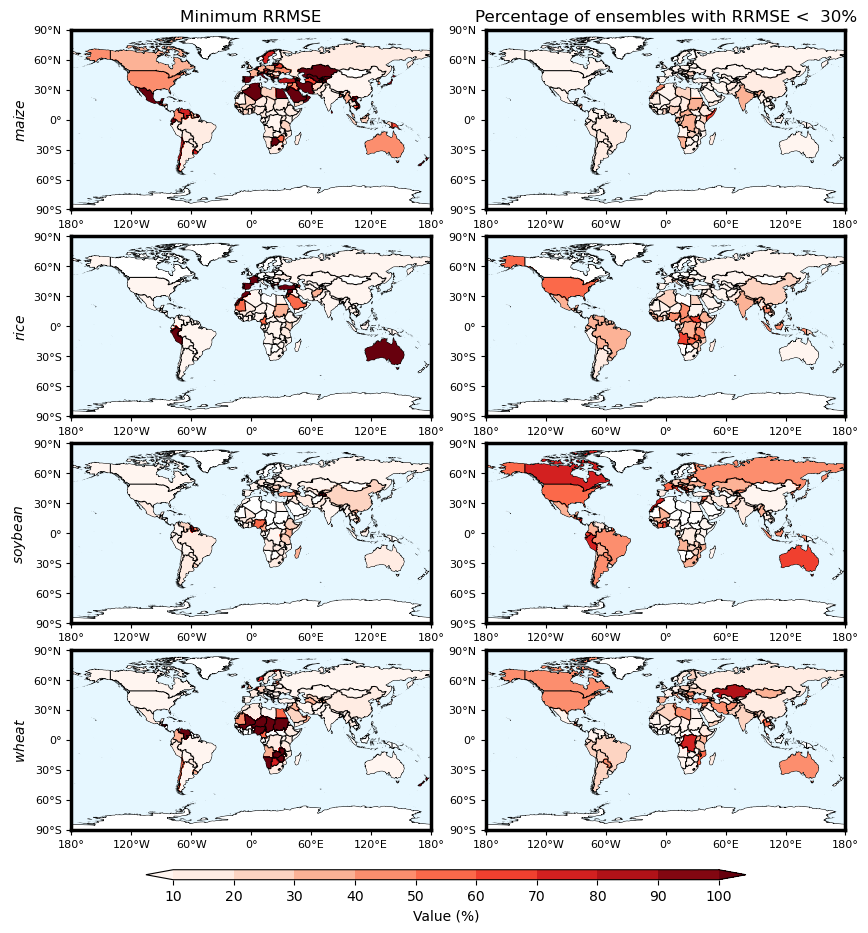

In [2]:
## 8. plot RRMSE

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_pre_CROP import create_global_map
plt.rcdefaults()

USE_IRR = 'all'
source = 'FAO'

yd_n = xr.load_dataarray(f'results/historical/dist_{source}_{USE_IRR}.nc')
yd1 = yd_n.min('new_dims')
thresh = 0.3
yd2 = xr.where(yd_n < thresh, 1, 0).sum('new_dims') / yd_n.notnull().sum('new_dims')
fig, axes = plt.subplots(4, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.0)})
for i, spc in enumerate(spcs4):
    ax0 = axes[i, 0]
    qt = 0.0
    if i == 0: ax0.set_title(f'Minimum RRMSE')
    ax0.set_ylabel(rf'${crop_mapping[spc]}$')
    # Emulated yield
    ax0, cf = create_global_map(yd1.sel(spc_crop=spc) * 100, 
                region='national', 
                levels=np.linspace(10, 100, 10), 
                ax=ax0, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'Reds'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax0.tick_params(axis='both', which='major', labelsize=8)

    ax1 = axes[i, 1]
    
    if i == 0: ax1.set_title(f'Percentage of ensembles with RRMSE < {thresh*100: .0f}%')
    ax1, cf = create_global_map(yd2.sel(spc_crop=spc) * 100, 
                region='national',
                levels=np.linspace(10, 100, 10), 
                ax=ax1, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'Reds'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax1.tick_params(axis='both', which='major', labelsize=8)

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.15, wspace=0.15)
cbar_ax1 = fig.add_axes([0.2, 0.05, 0.6, 0.01])  # [left, bottom, width, height]
fig.colorbar(cf, cax=cbar_ax1, label=rf'Value (%)', orientation='horizontal', extend='max', ticks=np.linspace(10, 100, 10), extendrect=False)
plt.show()

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-16 14:47:54.667507
++++++++++++++++++++++++++++++++++++++++++++++++++ 



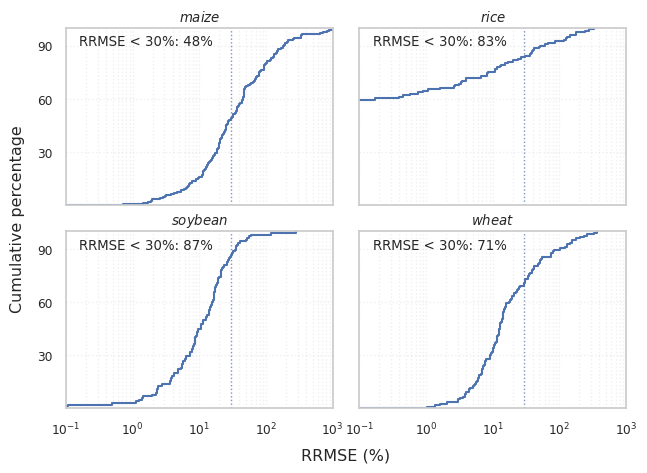

In [7]:
## 9. plot the density of RRMSE

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

plt.rcdefaults()

USE_IRR = 'all'
source = 'FAO'
yd_n = xr.load_dataarray(f'results/historical/dist_{source}_{USE_IRR}.nc').min('new_dims')*100

# Set Seaborn style
sns.set_theme(style="whitegrid", font_scale=0.8)
plt.rcParams['axes.unicode_minus'] = False

# Color palette for irrigation types
palette = {'firr': 'green', 'noirr': 'orange'}

fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True, gridspec_kw={'hspace': 0.15, 'wspace': 0.1, 'left': 0.1, 'bottom': 0.12})
legend_handles = []
label_handles = []
for s, spc in enumerate(spcs4):
    ax = axes.flat[s]
    ax.set_title(rf'${crop_mapping[spc]}$', pad=10, fontsize='medium', y=0.96)
    ax.set_xscale('log')
    ax.set_xlim(0.1, 1000)
    ax.set_ylim(0, 100)
    ax.grid(True, which='both', ls=':', alpha=0.3)
    ax.xaxis.set_major_locator(ticker.LogitLocator())
    ax.xaxis.set_major_locator(ticker.FixedLocator([0.1, 1, 10, 100, 1000]))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_locator(ticker.FixedLocator([30, 60, 90]))
    
    val = 30
    yd_values = yd_n.sel(spc_crop=spc, drop=True).dropna('reg_land').values.ravel()
    pt = np.sum(yd_values < val) / yd_values.size
    
    # Plot CDF using Seaborn
    sns.ecdfplot(
        data=yd_values,
        ax=ax,
        stat='percent',
        linewidth=1.5,
    )
    
    # Add percentile line
    ax.axvline(
        val, 
        linestyle=':', 
        linewidth=1,
        alpha=0.7
    )

    ax.text(0.05, 0.9, rf'RRMSE < {val}%: {pt*100:.0f}%', transform=ax.transAxes)
    ax.set_ylabel('')

# 🔹 Legend & Title
fig.supylabel('Cumulative percentage', fontsize='large')
fig.supxlabel(r'RRMSE (%)', fontsize='large')
plt.show()

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-06-16 14:48:20.310368
++++++++++++++++++++++++++++++++++++++++++++++++++ 

>>> Running stack_dims <<<
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<


ValueError: operands could not be broadcast together with shapes (360,720) (62,) (360,720) 

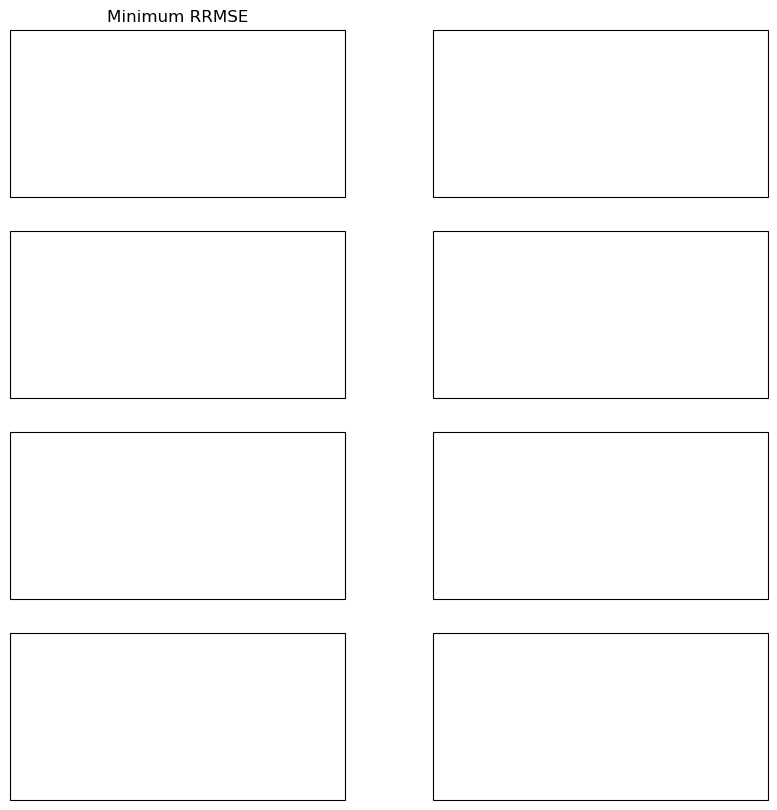

In [8]:
## 10. minimum RRMSE crop yields

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_pre_CROP import create_global_map, stack_dims
plt.rcdefaults()

USE_IRR = 'all'
source = 'FAO'

yd_obs = xr.load_dataarray(f'input_data/observations/crop/yield__{source}_national.nc').sel(year=slice(1960, run_yr[-1])).rename('YD_in')
yd = xr.load_dataarray(f'results/historical/YD4_{USE_IRR}.nc').sel(year=slice(1960, run_yr[-1])).rename('YD')
yd = stack_dims(yd, ['config', 'data_clim', 'data_N_fertl', 'data_Ac', 'data_Ah'], 'new_dims')
yd_n = xr.load_dataarray(f'results/historical/dist_{source}_{USE_IRR}.nc')
yd1 = (yd.where(yd_n == yd_n.min('new_dims'), drop=True).mean('new_dims') - yd_obs.mean('year')) / yd_obs.mean('year') 
thresh = 0.3
yd2 = (yd.where(yd_n < thresh).mean('new_dims') - yd_obs.mean('year')) /  yd_obs.mean('year')
fig, axes = plt.subplots(4, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.0)})
for i, spc in enumerate(spcs4):
    ax0 = axes[i, 0]
    qt = 0.0
    if i == 0: ax0.set_title(f'Minimum RRMSE')
    ax0.set_ylabel(rf'${crop_mapping[spc]}$')
    # Emulated yield
    ax0, cf = create_global_map(yd1.sel(spc_crop=spc) * 100, 
                region='national', 
                levels=np.linspace(-100, 100, 11), 
                ax=ax0, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'bwr'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax0.tick_params(axis='both', which='major', labelsize=8)

    ax1 = axes[i, 1]
    
    if i == 0: ax1.set_title(f'Percentage of ensembles with RRMSE < {thresh*100: .0f}%')
    ax1, cf = create_global_map(yd2.sel(spc_crop=spc) * 100, 
                region='national',
                levels=np.linspace(-100, 100, 11), 
                ax=ax1, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'bwr'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax1.tick_params(axis='both', which='major', labelsize=8)

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.15, wspace=0.15)
cbar_ax1 = fig.add_axes([0.2, 0.05, 0.6, 0.01])  # [left, bottom, width, height]
fig.colorbar(cf, cax=cbar_ax1, label=rf'Value (%)', orientation='horizontal', extend='max', ticks=np.linspace(-100, 100, 11), extendrect=False)
plt.show()